  # PostProcessing
  This notebook is initially designed for PostProcessing ASETS-II numerical and experimental data.
  It can also be used for other configurations's numerical results. But if you want to compare with other experimental data with a different format than ASETS-II. You should find a way to read them to RTD and RTDt in this notebook.

In [2]:
using ComputationalHeatTransfer
using Plots
# using Interact

  # Read simulation data

In [6]:
# cd("/Users/yuxuanli/Documents/Hoffman/workdir/numedata")
# cd("/Users/yuxuanli/Documents/Hoffman/ohp141/numedata")
cd("/Users/yuxuanli/Documents/Hoffman/ohp162/numedata")

In [7]:
# read_path = "../numedata/solution.jld2"
read_path = "../numedata/ASETS-L-2-40.jld2"
# read_path = "../numedata/OHP-JPL-200W.jld2"
# read_path = "../numedata/ASETS-40-r070-n025.jld2"
SimuResult = load(read_path)["SimulationResult"];

  ### get time array

In [8]:
t = SimuResult.tube_hist_t;

  # Plot 2D interpolated curves

  ### Interpolate 2D T data from the plate for fixed sensors on the plate

  place the 2D sensors

In [4]:
# x2Dsensors = [0.0,0.0] 
# y2Dsensors = [-60e-3,60e-3] 
x2Dsensors = [-2.9,-1.4,-0.8,0.0,0.0,0.8,1.4,2.9] .* inches
y2Dsensors = [0.0,   0.0, 0.0,0.0,0.4,0.0,0.0,0.0] .* inches
plate_sensors = (x2Dsensors,y2Dsensors);

  get the curve

In [5]:
t_hist,g_hist = getTcurve(plate_sensors,SimuResult);

  ### Read experiment T data
  This part can be customized as long as you can get a matrix for RTD (sensor data) and an array for RTDt (time points)

In [6]:
import XLSX

[ Info: Precompiling XLSX [fdbf4ff8-1666-58a4-91e7-1b58723a45e0]


 read experiment file for ASETS-II data.

In [7]:
cd("/Users/yuxuanli/Documents/Hoffman/ohp95/numedata")
expfile = expfileDict["O001_H001_P040"]
exppath = "../expdata/"
xf = XLSX.readxlsx(exppath*expfile);

  get experiment data for ASETS-II data

In [8]:
Onum, Hnum, power_exp = getconfig(expfile)
RTDt,RTD = getRTD(xf,Onum);

  ### 2D interpolated temperature curve at fixed sensors

In [9]:
# RTD_for_plotting = [1,2];
RTD_for_plotting = [1,4,8];


plot OHP

In [10]:
power = SimuResult.integrator_tube.p.wall.power

40.0

  ### 2D interpolated thermal conductance

In [11]:
ihot = 4 # hot sensor  for calculating thermal conductance
icold = 8# cold sensor  for calculating thermal conductance;

8

  ### get boiling data (if there are any)

In [12]:
if length(SimuResult.boil_hist) != 0
boil_data,boil_num_x,boil_num_t,t_boil,x2D_boil,y2D_boil,boil_dt = get_boil_matrix(SimuResult::SimulationResult);
end

([566.0 1.609999999999888; 538.0 1.6199999999998869; … ; 103.0 9.900000000003194; 563.0 9.930000000003258], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 3.0;;], 0.1:0.1:9.9, [-0.06315155827711313, -0.06246232874687472, -0.0586345850914687, -0.05757721571554188, -0.05329644262423894, -0.0531720246347527, -0.04211680676579056, -0.040717505483326186, -0.01767553019491646, -0.016000050628906012  …  -0.06076561973782803, -0.068915, -0.068915, -0.068915, -0.068915, -0.068915, -0.068915, -0.068915, -0.068915, -0.068915], [-0.023125, -0.023125, -0.023125, -0.023125, -0.023125, -0.023125, -0.023125000000000003, -0.023125, -0.023125, -0.023125  …  0.02312500000000029, 0.019678605661750812, 0.016540191459195823, 0.003821577773291624, -0.0023174050715818266, -0.007700695832680423, -0.012632974125892864, -0.01733131235926856, -0.020514331098762204, -0.020596350344689617], 0.1)

boiling frequency scatter graph (if there are any)

In [13]:
using EasyFit

[ Info: Precompiling EasyFit [fde71243-0cda-4261-b7c7-4845bd106b21]


In [14]:
m10 = movavg(vcat(boil_num_t...)./boil_dt,10);

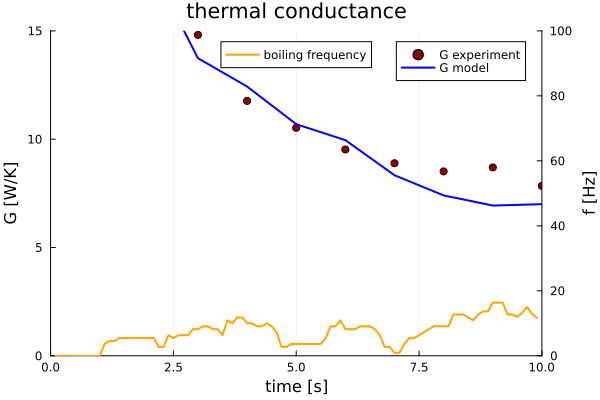

In [16]:
plot(OHPCond(),(ihot,icold),(t_hist,g_hist),(RTDt,RTD),SimuResult,ylim=(0,15))
plot!(twinx(),t_boil,m10.x,
color=:orange, xlim=(0,10),ylim=(0,100),legend=:top,linewidth=2, ylabel="f [Hz]", label="boiling frequency")
#       savefig("cond_curve.pdf")

In [5]:
ρₛ = 2730; # material density [kg/m^3]
cₛ  = 8.93e02; # material specific heat [J/kg K]
kₛ  = 1.93e02; # material heat conductivity
plate_d = 1.5e-3; # effective d (The thickness of an ideal uniform thickness plate occupying the same volume)
params = HeatConductionParameters(ρₛ ,cₛ ,kₛ ,thickness=plate_d)
Tref = 291.2 # reference temperature
fluid_type = "Butane"
p_fluid = SaturationFluidProperty(fluid_type,Tref)

Δx,Δt_max = setstepsizes(params.α,gridPe=8.0,fourier=0.3)
OHPtype = "ASETS-II OHP 1 LARGE HEATER"
power = 40 # total heater power in watts
Tc = Tref; # condenser temperature
eparams,cparams = OHPConfiguration(OHPtype,power,Tc,Δx,hc2ratio=0.07);

In [7]:
l = @layout [Plots.grid(3, 2)]

# l = @layout [a b; c d; e f]
p1 = plot(OHPSlug(),5  ,SimuResult, plain=true)
# annotate!(p1,[(0.055, -0.029, string(round(t[5], digits=2), "[s]"))],annotationcolor=:white)

# plot heaters (red)
for ep in eparams
    plot!(ep)
end

# plot condensers (blue)
for cp in [cparams[2]]
    plot!(cp)
end

# for cp in [cparams[1]]
#     plot!(cp)
# end

p2 = plot(OHPSlug(),10 ,SimuResult, plain=true)
annotate!(p2,[(0.055, -0.029, string(round(t[10], digits=2), "[s]"))],annotationcolor=:white)
p3 = plot(OHPSlug(),15 ,SimuResult, plain=true)
annotate!(p3,[(0.055, -0.029, string(round(t[15], digits=2), "[s]"))],annotationcolor=:white)
p4 = plot(OHPSlug(),20,SimuResult, plain=true)
annotate!(p4,[(0.055, -0.029, string(round(t[20], digits=2), "[s]"))],annotationcolor=:white)
p5 = plot(OHPSlug(),100 ,SimuResult, plain=true)
annotate!(p5,[(0.055, -0.029, string(round(t[100], digits=2), "[s]"))],annotationcolor=:white)
p6 = plot(OHPSlug(),300,SimuResult, plain=true)
annotate!(p6,[(0.055, -0.029, string(round(t[300], digits=2), "[s]"))],annotationcolor=:white)
plot(p1, p2,p3, p4,p5,p6,layout = l,size=(900,600),bottom_margin=-6mm,left_margin=-10mm)
# l = @layout [a ; b; c; d]
# p1 = plot(OHPSlug(),1  ,SimuResult,showaxis=false,xlabel="",ylabel="",colorbar=false,annotationfontsize=1,annotationcolor=:white)
# p2 = plot(OHPSlug(),10 ,SimuResult,showaxis=false,xlabel="",ylabel="",colorbar=false,annotationfontsize=1,annotationcolor=:white)
# p3 = plot(OHPSlug(),50 ,SimuResult,showaxis=false,xlabel="",ylabel="",colorbar=false,annotationfontsize=1,annotationcolor=:white)
# p4 = plot(OHPSlug(),100,SimuResult,showaxis=false,xlabel="",ylabel="",colorbar=false,annotationfontsize=1,annotationcolor=:white)
# plot(p1, p2,p3, p4,layout = l,size=(400,730),bottom_margin=-10mm)

savefig("ohp dryout.pdf")

"/Users/yuxuanli/Documents/Hoffman/ohp162/numedata/ohp dryout.pdf"

In [104]:
l = @layout [Plots.grid(3, 2) a{0.1w}]

Tmin = minimum(SimuResult.plate_T_hist[1][:])
Tmax = maximum(SimuResult.plate_T_hist[end][:])

h2 = scatter([1,1],markeralpha=0,zcolor=[0,0], clim=(Tmin,Tmax),
    xshowaxis=false, yshowaxis=false, tickfontsize =10,colorbar_titlefontsize=13,
    label="",  colorbar_title="\n T[K]", grid=false,right_margin = 6Plots.mm)

# l = @layout [a b; c d; e f]
p1 = plot(OHPTemp(),5  ,SimuResult,clim=(Tmin,Tmax),plain=true)
annotate!(p1,[(0.055, -0.029, string(round(t[5], digits=2), "[s]"))],annotationcolor=:white)
p2 = plot(OHPTemp(),10 ,SimuResult,clim=(Tmin,Tmax),plain=true)
annotate!(p2,[(0.055, -0.029, string(round(t[10], digits=2), "[s]"))],annotationcolor=:white)
p3 = plot(OHPTemp(),15 ,SimuResult,clim=(Tmin,Tmax),plain=true)
annotate!(p3,[(0.055, -0.029, string(round(t[15], digits=2), "[s]"))],annotationcolor=:white)
p4 = plot(OHPTemp(),20,SimuResult,clim=(Tmin,Tmax),plain=true)
annotate!(p4,[(0.055, -0.029, string(round(t[20], digits=2), "[s]"))],annotationcolor=:white)
p5 = plot(OHPTemp(),100 ,SimuResult,clim=(Tmin,Tmax),plain=true)
annotate!(p5,[(0.055, -0.029, string(round(t[100], digits=2), "[s]"))],annotationcolor=:white)
p6 = plot(OHPTemp(),300,SimuResult,clim=(Tmin,Tmax),plain=true)
annotate!(p6,[(0.055, -0.029, string(round(t[300], digits=2), "[s]"))],annotationcolor=:white)
plot(p1, p2,p3, p4,p5,p6,h2,layout = l,size=(900,490),bottom_margin=-6mm,left_margin=-10mm)
savefig("T contour.pdf")
# savefig("T contour dryout.pdf")

GKS: Rectangle definition is invalid in routine SET_VIEWPORT


"/Users/yuxuanli/Documents/Hoffman/ohp95/numedata/T contour.pdf"

  ### dryout case

In [131]:
cd("/Users/yuxuanli/Documents/Hoffman/ohp162/numedata")
read_path = "../numedata/ASETS-L-2-40.jld2"
SimuResult = load(read_path)["SimulationResult"];

In [106]:
t_hist,g_hist = getTcurve(plate_sensors,SimuResult);

In [107]:
cd("/Users/yuxuanli/Documents/Hoffman/ohp95/numedata")
expfile = expfileDict["O002_H001_P040"]
exppath = "../expdata/"
xf = XLSX.readxlsx(exppath*expfile);

In [108]:
Onum, Hnum, power_exp = getconfig(expfile)
RTDt,RTD = getRTD(xf,Onum);

In [109]:
if length(SimuResult.boil_hist) != 0
boil_data,boil_num_x,boil_num_t,t_boil,x2D_boil,y2D_boil,boil_dt = get_boil_matrix(SimuResult::SimulationResult);
end

([88.0 2.7499999999997624; 36.0 4.7599999999995415; … ; 10.0 234.55000000329213; 241.0 258.9900000041034], [5.0; 8.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 1.0;;], 0.1:0.1:259.0, [-0.041266614379100036, 0.007159650837879283, 0.016018438816322977, 0.018697185099937865, 0.028623112601812897, 0.03155675557471656, 0.04220363461263709, 0.057544726761539045, 0.01927919132375805, 0.002781309321315029  …  0.016643962656571136, 0.021413585668903248, 0.06615375314770464, 0.05453235914779503, 0.009564775717435248, -0.027722698256917165, -0.0347807157968054, -0.035780824010705904, -0.068915, -0.068915], [-0.023125, -0.023125, -0.023125, -0.023125, -0.023125000000000003, -0.023125, -0.023125, -0.023125, -0.021723484848484843, -0.02172348484848484  …  0.021723484848485124, 0.021723484848485124, 0.021723484848485124, 0.023125000000000277, 0.023125000000000277, 0.02312500000000029, 0.02312500000000029, 0.02312500000000029, 0.020912048077899627, -0.008446356850664829], 0.1)

In [110]:
m10 = movavg(vcat(boil_num_t...)./boil_dt,10);

In [112]:
plot(OHPCond(),(ihot,icold),(t_hist,g_hist),(RTDt,RTD),SimuResult,ylim=(0,5))
plot!(twinx(),t_boil,m10.x,
color=:orange, xlim=(0,300),ylim=(0,100),legend=:top,linewidth=2, ylabel="f [HZ]", label="boiling frequency")
      savefig("cond_curve dryout.pdf")

"/Users/yuxuanli/Documents/Hoffman/ohp95/numedata/cond_curve dryout.pdf"

In [114]:
l = @layout [Plots.grid(3, 2)]

# l = @layout [a b; c d; e f]
p1 = plot(OHPSlug(),5  ,SimuResult, plain=true)
annotate!(p1,[(0.055, -0.029, string(round(t[5], digits=2), "[s]"))],annotationcolor=:white)
p2 = plot(OHPSlug(),10 ,SimuResult, plain=true)
annotate!(p2,[(0.055, -0.029, string(round(t[10], digits=2), "[s]"))],annotationcolor=:white)
p3 = plot(OHPSlug(),15 ,SimuResult, plain=true)
annotate!(p3,[(0.055, -0.029, string(round(t[15], digits=2), "[s]"))],annotationcolor=:white)
p4 = plot(OHPSlug(),20,SimuResult, plain=true)
annotate!(p4,[(0.055, -0.029, string(round(t[20], digits=2), "[s]"))],annotationcolor=:white)
p5 = plot(OHPSlug(),100 ,SimuResult, plain=true)
annotate!(p5,[(0.055, -0.029, string(round(t[100], digits=2), "[s]"))],annotationcolor=:white)
p6 = plot(OHPSlug(),300,SimuResult, plain=true)
annotate!(p6,[(0.055, -0.029, string(round(t[300], digits=2), "[s]"))],annotationcolor=:white)
plot(p1, p2,p3, p4,p5,p6,layout = l,size=(900,600),bottom_margin=-6mm,left_margin=-10mm)
# l = @layout [a ; b; c; d]
# p1 = plot(OHPSlug(),1  ,SimuResult,showaxis=false,xlabel="",ylabel="",colorbar=false,annotationfontsize=1,annotationcolor=:white)
# p2 = plot(OHPSlug(),10 ,SimuResult,showaxis=false,xlabel="",ylabel="",colorbar=false,annotationfontsize=1,annotationcolor=:white)
# p3 = plot(OHPSlug(),50 ,SimuResult,showaxis=false,xlabel="",ylabel="",colorbar=false,annotationfontsize=1,annotationcolor=:white)
# p4 = plot(OHPSlug(),100,SimuResult,showaxis=false,xlabel="",ylabel="",colorbar=false,annotationfontsize=1,annotationcolor=:white)
# plot(p1, p2,p3, p4,layout = l,size=(400,730),bottom_margin=-10mm)

savefig("ohp dryout.pdf")

"/Users/yuxuanli/Documents/Hoffman/ohp95/numedata/ohp dryout.pdf"

In [116]:
l = @layout [Plots.grid(3, 2) a{0.1w}]

Tmin = minimum(SimuResult.plate_T_hist[1][:])
Tmax = maximum(SimuResult.plate_T_hist[end][:])

h2 = scatter([1,1],markeralpha=0,zcolor=[0,0], clim=(Tmin,Tmax),
    xshowaxis=false, yshowaxis=false, tickfontsize =10,colorbar_titlefontsize=13,
    label="",  colorbar_title="\n T[K]", grid=false,right_margin = 6Plots.mm)

# l = @layout [a b; c d; e f]
p1 = plot(OHPTemp(),5  ,SimuResult,clim=(Tmin,Tmax),plain=true)
annotate!(p1,[(0.055, -0.029, string(round(t[5], digits=2), "[s]"))],annotationcolor=:white)
p2 = plot(OHPTemp(),10 ,SimuResult,clim=(Tmin,Tmax),plain=true)
annotate!(p2,[(0.055, -0.029, string(round(t[10], digits=2), "[s]"))],annotationcolor=:white)
p3 = plot(OHPTemp(),15 ,SimuResult,clim=(Tmin,Tmax),plain=true)
annotate!(p3,[(0.055, -0.029, string(round(t[15], digits=2), "[s]"))],annotationcolor=:white)
p4 = plot(OHPTemp(),20,SimuResult,clim=(Tmin,Tmax),plain=true)
annotate!(p4,[(0.055, -0.029, string(round(t[20], digits=2), "[s]"))],annotationcolor=:white)
p5 = plot(OHPTemp(),100 ,SimuResult,clim=(Tmin,Tmax),plain=true)
annotate!(p5,[(0.055, -0.029, string(round(t[100], digits=2), "[s]"))],annotationcolor=:white)
p6 = plot(OHPTemp(),300,SimuResult,clim=(Tmin,Tmax),plain=true)
annotate!(p6,[(0.055, -0.029, string(round(t[300], digits=2), "[s]"))],annotationcolor=:white)
plot(p1, p2,p3, p4,p5,p6,h2,layout = l,size=(900,490),bottom_margin=-6mm,left_margin=-10mm)
# savefig("T contour.pdf")
savefig("T contour dryout.pdf")

GKS: Rectangle definition is invalid in routine SET_VIEWPORT


"/Users/yuxuanli/Documents/Hoffman/ohp95/numedata/T contour dryout.pdf"

In [118]:
using Statistics

In [120]:
function get_avgδ(SimuResult::SimulationResult)
    t = SimuResult.tube_hist_t;
    tube_sys = getcurrentsys!.(SimuResult.tube_hist_u,[SimuResult.integrator_tube.p]);
    
    filmLδend = [x.vapor.Lfilm_end.*x.vapor.δend for x in tube_sys]
    filmLδstart = [x.vapor.Lfilm_start.*x.vapor.δstart for x in tube_sys]
#     filmδend = [x.vapor.δend for x in tube_sys]
#     filmδstart = [x.vapor.δstart for x in tube_sys]
    filmLend = [x.vapor.Lfilm_end for x in tube_sys]
    filmLstart = [x.vapor.Lfilm_start for x in tube_sys]
    filmLtotal = sum.(filmLend) .+ sum.(filmLstart)
    avgδ = sum.(filmLδend) .+ sum.(filmLδstart) ./ filmLtotal
    
    starti = floor(Int64,length(t)/2)
    mean(avgδ[starti:end])
end

get_avgδ (generic function with 1 method)

In [124]:
cd("/Users/yuxuanli/Documents/Hoffman/ohp162/numedata")
read_path_array = [
"../numedata/ASETS-L-1-10.jld2",
"../numedata/ASETS-L-1-20.jld2",
"../numedata/ASETS-L-1-30.jld2",
"../numedata/ASETS-L-1-40.jld2",
"../numedata/ASETS-S-1-10.jld2",
"../numedata/ASETS-S-1-20.jld2",
"../numedata/ASETS-S-1-30.jld2",
"../numedata/ASETS-S-1-40.jld2",
"../numedata/ASETS-L-2-10.jld2",
"../numedata/ASETS-L-2-20.jld2",
"../numedata/ASETS-L-2-30.jld2",
"../numedata/ASETS-L-2-40.jld2",
"../numedata/ASETS-S-2-10.jld2",
"../numedata/ASETS-S-2-20.jld2",
"../numedata/ASETS-S-2-30.jld2",
"../numedata/ASETS-S-2-40.jld2"
]
exp_path_array = [
    "O001_H001_P010",
    "O001_H001_P020",
    "O001_H001_P030",
    "O001_H001_P040",
    "O001_H002_P010",
    "O001_H002_P020",
    "O001_H002_P030",
    "O001_H002_P040",
    "O002_H001_P010",
    "O002_H001_P020",
    "O002_H001_P030",
    "O002_H001_P040",
    "O002_H002_P010",
    "O002_H002_P020",
    "O002_H002_P030",
    "O002_H002_P040"
]
conductance_array = zeros(size(read_path_array))
expcond_array = zeros(size(read_path_array))
avgδ_array = zeros(size(read_path_array))
nume_postdryout = 0.0
exp_postdryout = 0.0
        
for i in eachindex(read_path_array)
    SimuResult = load(read_path_array[i])["SimulationResult"];

    t_hist,g_hist = getTcurve(plate_sensors,SimuResult);
    power = SimuResult.integrator_tube.p.wall.power
    
    println(i,power)
    
    ihot = 4 # hot sensor  for calculating thermal conductance
    icold = 8 # c
    cond = power ./ (g_hist[:,ihot] .- g_hist[:,icold])

    conductance_array[i] = mean(cond[100:200])
    avgδ_array[i] = get_avgδ(SimuResult)
    
    
    expfile = expfileDict[exp_path_array[i]]
    exppath = "/Users/yuxuanli/Documents/Hoffman/ohp95/expdata/"
    xf = XLSX.readxlsx(exppath*expfile);
    
    Onum, Hnum, power_exp = getconfig(expfile)
    RTDt,RTD = getRTD(xf,Onum);
    
    cond_exp = power ./ (RTD[:,ihot] .- RTD[:,icold])
    
    expcond_array[i] = mean(cond_exp[100:200])
    
    if exp_path_array[i] == "O002_H001_P040"
        exp_postdryout = mean(cond_exp[250:300])
        nume_postdryout = mean(cond[250:300])
    end
end

110.0
220.0
330.0
440.0
510.0
620.0
730.0
840.0
910.0
1020.0
1130.0
1240.0
1310.0
1420.0
1530.0
1640.0


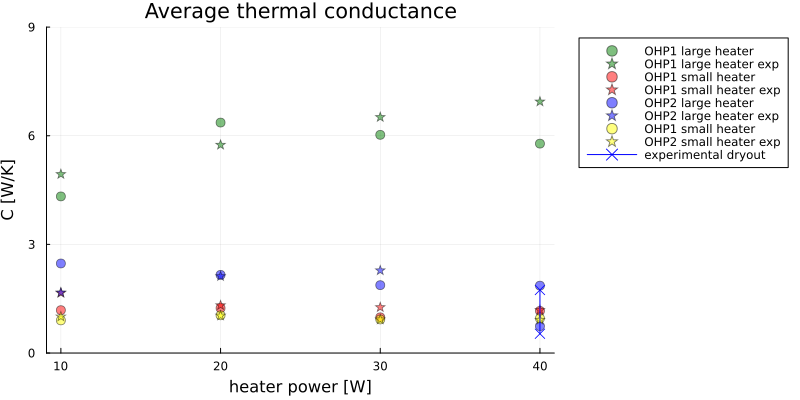

In [125]:
gr()
powers = [10,20,30,40]
scatter(powers,conductance_array[1:4],markercolor = :green,markersize=5,markeralpha=0.5,label="OHP1 large heater")
scatter!(powers,expcond_array[1:4],markercolor = :green,marker=:star,markersize=5,markeralpha=0.5,label="OHP1 large heater exp")
scatter!(powers,conductance_array[5:8],markercolor = :red,markersize=5,markeralpha=0.5,label="OHP1 small heater")
scatter!(powers,expcond_array[5:8],markercolor = :red,marker=:star,markersize=5,markeralpha=0.5,label="OHP1 small heater exp")
scatter!([powers[1:4];powers[4]],[conductance_array[9:12];nume_postdryout],markercolor = :blue,markersize=5,markeralpha=0.5,label="OHP2 large heater")
scatter!(powers[1:3],expcond_array[9:11],markercolor = :blue,marker=:star,markersize=5,markeralpha=0.5,label="OHP2 large heater exp")
scatter!(powers,conductance_array[13:16],markercolor = :yellow,markersize=5,markeralpha=0.5,label="OHP1 small heater")
scatter!(powers,expcond_array[13:16],markercolor = :yellow,marker=:star,markersize=5,markeralpha=0.5,label="OHP2 small heater exp")
plot!([40,40],[expcond_array[12],exp_postdryout],xlabel="heater power [W]",ylabel="C [W/K]",title="Average thermal conductance",
legend=:outertopright,ylim=(0,9),size=(800,400),left_margin=2Plots.mm,bottom_margin=3Plots.mm,markersize=5,marker=:xcross,color=:blue,label="experimental dryout")
# scatter!([40,40],[conductance_array[12],nume_predryout],size=(900,400),
# legend=:outertopright,ylim=(0,8),markersize=5,marker=:hexagon,color=:green,markeralpha=0.5,label="numerical dryout")
# savefig("conductance all.pdf")

In [752]:
powers = [10,20,30,40]
scatter(powers,avgδ_array[1:4],markercolor = :green,markersize=5,markeralpha=0.5,label="OHP1 large heater")
# scatter!(powers,expcond_array[1:4],markercolor = :green,marker=:star,markersize=5,markeralpha=0.5,label="OHP1 large heater exp")
scatter!(powers,avgδ_array[5:8],markercolor = :red,markersize=5,markeralpha=0.5,label="OHP1 small heater")
# scatter!(powers,expcond_array[5:8],markercolor = :red,marker=:star,markersize=5,markeralpha=0.5,label="OHP1 small heater exp")
scatter!(powers[1:4],avgδ_array[9:12],markercolor = :blue,markersize=5,markeralpha=0.5,label="OHP2 large heater")
# scatter!(powers[1:4],expcond_array[9:12],markercolor = :blue,marker=:star,markersize=5,markeralpha=0.5,label="OHP2 large heater exp")
scatter!(powers,avgδ_array[13:16],markercolor = :yellow,markersize=5,markeralpha=0.5,label="OHP2 small heater")
# scatter!(powers,expcond_array[13:16],markercolor = :yellow,marker=:star,markersize=5,markeralpha=0.5,label="OHP2 small heater exp")
plot!(xlabel="heater power [W]",ylabel="δavg [m]",title="Average liquid film thickness",
legend=:topleft,ylim=(0,5e-5),markersize=5,marker=:xcross,color=:blue)
# scatter!([40,40],[conductance_array[12],nume_predryout],size=(900,400),
# legend=:outertopright,ylim=(0,8),markersize=5,marker=:hexagon,color=:green,markeralpha=0.5,label="numerical dryout")
savefig("film thickness all.pdf")

"/Users/yuxuanli/Documents/Hoffman/ohp95/numedata/film thickness all.pdf"

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*

In [9]:
read_path = "../numedata/ASETS-L-1-40.jld2"
SimuResult = load(read_path)["SimulationResult"];

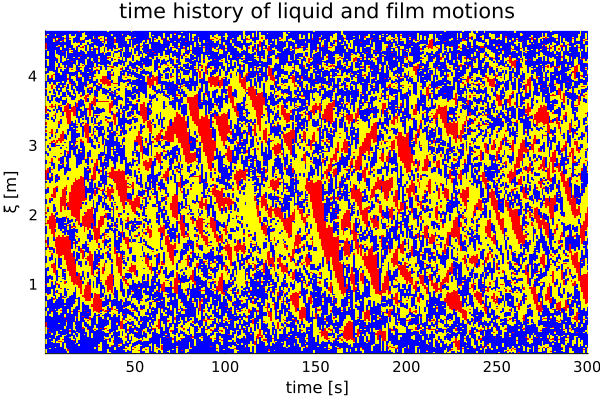

In [10]:
tube_sys=getcurrentsys.(SimuResult.tube_hist_u,[SimuResult.integrator_tube.p])
sluginterp = slug_interp.(tube_sys)
    xs =  tube_sys[1].wall.Xarray
    markers  = map.(sluginterp, [xs])
matrix_markers = hcat(markers...)
heatmap(t,xs,matrix_markers,xlabel="time [s]",ylabel="ξ [m]",title="time history of liquid and film motions",
c = palette([:red, :blue, :yellow], 3),colorbar=false,tickfontsize=10)
# savefig("time hist.pdf")

In [147]:
read_path = "../numedata/ASETS-S-1-40.jld2"
SimuResult = load(read_path)["SimulationResult"];

In [149]:
tube_sys=getcurrentsys.(SimuResult.tube_hist_u,[SimuResult.integrator_tube.p])
sluginterp = slug_interp.(tube_sys)
    xs =  tube_sys[1].wall.Xarray
    markers  = map.(sluginterp, [xs])
matrix_markers = hcat(markers...)
heatmap(t,xs,matrix_markers,xlabel="time [s]",ylabel="ξ [m]",title="time history of liquid and film motions",
c = palette([:red, :blue, :yellow], 3),colorbar=false,tickfontsize=10)
savefig("time hist small.pdf")

"/Users/yuxuanli/Documents/Hoffman/ohp162/numedata/time hist small.pdf"

In [140]:
read_path = "../numedata/ASETS-S-2-40.jld2"
SimuResult = load(read_path)["SimulationResult"];

In [142]:
tube_sys=getcurrentsys.(SimuResult.tube_hist_u,[SimuResult.integrator_tube.p])
sluginterp = slug_interp.(tube_sys)
    xs =  tube_sys[1].wall.Xarray
    markers  = map.(sluginterp, [xs])
matrix_markers = hcat(markers...)
heatmap(t,xs,matrix_markers,xlabel="time [s]",ylabel="ξ [m]",title="time history of liquid and film motions",
c = palette([:red, :blue, :yellow], 3),colorbar=false,tickfontsize=10)
savefig("time hist small dryout.pdf")

"/Users/yuxuanli/Documents/Hoffman/ohp162/numedata/time hist small dryout.pdf"

In [150]:
read_path = "../numedata/ASETS-L-2-40.jld2"
SimuResult = load(read_path)["SimulationResult"];

In [151]:
tube_sys=getcurrentsys.(SimuResult.tube_hist_u,[SimuResult.integrator_tube.p])
sluginterp = slug_interp.(tube_sys)
    xs =  tube_sys[1].wall.Xarray
    markers  = map.(sluginterp, [xs])
matrix_markers = hcat(markers...)
heatmap(t,xs,matrix_markers,xlabel="time [s]",ylabel="ξ [m]",title="time history of liquid and film motions",
c = palette([:red, :blue, :yellow], 3),colorbar=false,tickfontsize=10)
savefig("time hist dryout.pdf")

"/Users/yuxuanli/Documents/Hoffman/ohp162/numedata/time hist dryout.pdf"

In [15]:
heaviside(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.0)))

heaviside (generic function with 1 method)

In [74]:
function latent_sensible_heat(SimuResult::SimulationResult)
    tube_sys = getcurrentsys.(SimuResult.tube_hist_u,[SimuResult.integrator_tube.p])
    for i in eachindex(tube_sys)
        tube_sys[i].wall.θarray = deepcopy(SimuResult.tube_hist_θwall[i])
    end

    Harray = sys_to_Harray.(tube_sys)

     sluginterp = slug_interp.(tube_sys)
        xs =  tube_sys[1].wall.Xarray
    dx =  tube_sys[1].tube.L / tube_sys[1].tube.N
        markers  = map.(sluginterp, [xs])

    # θ_wall = [elem.mapping.θ_interp_walltoliquid[xs] for elem in tube_sys]
    θ_liquid = [elem.mapping.θ_interp_liquidtowall[xs] for elem in tube_sys]
    θ_wall = SimuResult.tube_hist_θwall
    new_markers = [sign.(elem .- 1.5) for elem in markers]

    peri = tube_sys[1].tube.peri

    latent_flux = [dx .* peri .* heaviside.(new_markers[i]) .* (θ_wall[i] .- θ_liquid[i]) .* Harray[i] for i in eachindex(tube_sys)]
    sensible_flux =   [dx .* peri .* heaviside.(-new_markers[i]) .* (θ_wall[i] .- θ_liquid[i]) .* Harray[i] for i in eachindex(tube_sys)];
                    
    latent_flux,sensible_flux
end

latent_sensible_heat (generic function with 1 method)

In [87]:
read_path = "../numedata/ASETS-L-1-20.jld2"
SimuResult = load(read_path)["SimulationResult"];

In [88]:
latent_flux,sensible_flux = latent_sensible_heat(SimuResult);

In [93]:
latent_hist_positive = [sum(elem .* heaviside.(elem)) for elem in latent_flux]
latent_hist_negative = [sum(elem .* heaviside.(-elem)) for elem in latent_flux]
sensible_hist_positive = [sum(elem .* heaviside.(elem)) for elem in sensible_flux]
sensible_hist_negative = [sum(elem .* heaviside.(-elem)) for elem in sensible_flux]

plot(t,latent_hist_positive,label="positive latent heat",linewidth=2)
plot!(t,latent_hist_negative,label="negative latent heat",linewidth=2)
plot!(t,sensible_hist_positive,label="positive sensible heat",linewidth=2)                
plot!(t,sensible_hist_negative,label="negative sensible heat",legend=:topleft,linewidth=2)
# plot!(ylim=(-120,120),xlabel="time [s]", ylabel="latent heat or sensible heat [W]",title="sensible and latent heat")
plot!(ylim=(-60,60),xlabel="time [s]", ylabel="latent heat or sensible heat [W]",title="sensible and latent heat",dpi=600)
# plot!(t_boil,m10.x,xlim=(0,100))
savefig("heat hist 20W.png")

"/Users/yuxuanli/Documents/Hoffman/ohp162/numedata/heat hist 20W.png"

In [96]:
read_path = "../numedata/ASETS-L-2-20.jld2"
SimuResult = load(read_path)["SimulationResult"];

In [97]:
latent_flux,sensible_flux = latent_sensible_heat(SimuResult);

In [98]:
latent_hist_positive = [sum(elem .* heaviside.(elem)) for elem in latent_flux]
latent_hist_negative = [sum(elem .* heaviside.(-elem)) for elem in latent_flux]
sensible_hist_positive = [sum(elem .* heaviside.(elem)) for elem in sensible_flux]
sensible_hist_negative = [sum(elem .* heaviside.(-elem)) for elem in sensible_flux]

plot(t,latent_hist_positive,label="positive latent heat",linewidth=2)
plot!(t,latent_hist_negative,label="negative latent heat",linewidth=2)
plot!(t,sensible_hist_positive,label="positive sensible heat",linewidth=2)                
plot!(t,sensible_hist_negative,label="negative sensible heat",legend=:topleft,linewidth=2)
# plot!(ylim=(-120,120),xlabel="time [s]", ylabel="latent heat or sensible heat [W]",title="sensible and latent heat")
plot!(ylim=(-60,60),xlabel="time [s]", ylabel="latent heat or sensible heat [W]",title="sensible and latent heat",dpi=600)
# plot!(t_boil,m10.x,xlim=(0,100))
savefig("heat hist dryout 20W.png")

"/Users/yuxuanli/Documents/Hoffman/ohp162/numedata/heat hist dryout 20W.png"

In [103]:
read_path = "../numedata/ASETS-S-1-20.jld2"
SimuResult = load(read_path)["SimulationResult"];

In [104]:
latent_flux,sensible_flux = latent_sensible_heat(SimuResult);

In [105]:
latent_hist_positive = [sum(elem .* heaviside.(elem)) for elem in latent_flux]
latent_hist_negative = [sum(elem .* heaviside.(-elem)) for elem in latent_flux]
sensible_hist_positive = [sum(elem .* heaviside.(elem)) for elem in sensible_flux]
sensible_hist_negative = [sum(elem .* heaviside.(-elem)) for elem in sensible_flux]

plot(t,latent_hist_positive,label="positive latent heat",linewidth=2)
plot!(t,latent_hist_negative,label="negative latent heat",linewidth=2)
plot!(t,sensible_hist_positive,label="positive sensible heat",linewidth=2)                
plot!(t,sensible_hist_negative,label="negative sensible heat",legend=:topleft,linewidth=2)
# plot!(ylim=(-120,120),xlabel="time [s]", ylabel="latent heat or sensible heat [W]",title="sensible and latent heat")
plot!(ylim=(-60,60),xlabel="time [s]", ylabel="latent heat or sensible heat [W]",title="sensible and latent heat",dpi=600)
# plot!(t_boil,m10.x,xlim=(0,100))
savefig("heat hist small 20W.png")

"/Users/yuxuanli/Documents/Hoffman/ohp162/numedata/heat hist small 20W.png"

In [106]:
read_path = "../numedata/ASETS-S-2-20.jld2"
SimuResult = load(read_path)["SimulationResult"];

In [107]:
latent_flux,sensible_flux = latent_sensible_heat(SimuResult);

In [108]:
latent_hist_positive = [sum(elem .* heaviside.(elem)) for elem in latent_flux]
latent_hist_negative = [sum(elem .* heaviside.(-elem)) for elem in latent_flux]
sensible_hist_positive = [sum(elem .* heaviside.(elem)) for elem in sensible_flux]
sensible_hist_negative = [sum(elem .* heaviside.(-elem)) for elem in sensible_flux]

plot(t,latent_hist_positive,label="positive latent heat",linewidth=2)
plot!(t,latent_hist_negative,label="negative latent heat",linewidth=2)
plot!(t,sensible_hist_positive,label="positive sensible heat",linewidth=2)                
plot!(t,sensible_hist_negative,label="negative sensible heat",legend=:topleft,linewidth=2)
# plot!(ylim=(-120,120),xlabel="time [s]", ylabel="latent heat or sensible heat [W]",title="sensible and latent heat")
plot!(ylim=(-60,60),xlabel="time [s]", ylabel="latent heat or sensible heat [W]",title="sensible and latent heat",dpi=600)
# plot!(t_boil,m10.x,xlim=(0,100))
savefig("heat hist small dryout 20W.png")

"/Users/yuxuanli/Documents/Hoffman/ohp162/numedata/heat hist small dryout 20W.png"

In [186]:
# latent_hist = [sum((elem)) for elem in latent_flux]
# sensible_hist = [sum((elem)) for elem in sensible_flux]

# plot(latent_hist,label="net latent heat",linewidth=2)
# plot!(sensible_hist,label="net sensible heat",legend=:topright,linewidth=2)
# plot!(xlabel="time [s]", ylabel="latent heat or sensible heat [W]",title="net sensible and latent heat")
# # plot!(t_boil,m10.x,xlim=(0,100))
# # savefig("net sensible and latent heat for OHP1 large heater 40W.pdf")

## 1st revision

In [67]:
using Statistics

In [78]:
# OHP1 large heater

In [79]:
(mean(latent_hist_positive) - mean(latent_hist_negative))/2

31.322107130129353

In [80]:
(mean(sensible_hist_positive) - mean(sensible_hist_negative))/2

3.0474095171758426

In [71]:
# OHP1 small heater

In [85]:
(mean(latent_hist_positive) - mean(latent_hist_negative))/2

27.299067978428184

In [86]:
(mean(sensible_hist_positive) - mean(sensible_hist_negative))/2

6.197624579777425